In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import mpmath
import math
from decimal import Decimal,getcontext

In [2]:
stai_scores = np.array(pd.read_csv(r'stai_scores.csv', header=None)[0])
inst_choices = np.array(pd.read_csv(r'inst_choices.csv', header=None))
inst_outcomes = np.array(pd.read_csv(r'inst_outcomes.csv', header=None))

### Data exploration

In [3]:
# Exploring the data: mean, median, standard deviation of STAI
overall_mean = np.mean(stai_scores)
overall_std = np.std(stai_scores)
overall_median = np.median(stai_scores)

anxious_mean = np.mean(stai_scores[0:24])
anxious_std = np.std(stai_scores[0:24])
anxious_median = np.median(stai_scores[0:24])

control_mean = np.mean(stai_scores[25:])
control_std = np.std(stai_scores[25:])
control_median = np.median(stai_scores[25:])

In [4]:
# Exploring the data: cut-off = 43, ANXIOUS group if STAI>43
cut_off_stai = np.zeros(len(stai_scores))
for i in range(len(stai_scores)):
    if stai_scores[i] <= 43:
        # cut_off_stai = 1 if the subject is in the healthy control group
        cut_off_stai[i] = 1

healthy_num = sum(cut_off_stai)
healthy_index = np.where(cut_off_stai==1)

In [5]:
# Exploring the data: number of times each subject choosing stimuli A
chose_a_count = []
chose_a_percent = []
for i in range(len(inst_choices)):
    chose_a_count.append(np.array(np.where(inst_choices[i]==1)).size)
    chose_a_percent.append(chose_a_count[-1]/len(inst_choices[i]))

### Simulation


In [6]:
# Value of a chosen stimuli i at time t, and the overall outcome
# the probability of each stimulus to lead to the aversive noise, 70/30, 80/20, 60/40, 65/35 (A/B)
# A reinforcement learning model, the Rescorla-Wagner model, to update the subjective value
# of A and B after each trial. The value of A and B at trial i+1 is updated based on
# the prediction error of the chosen option at trial i. This means that
# if the outcome is better than expected, the subjective value of the chosen option is increased, and 
# if the outcome is worse than expected, the subjective value of the chosen option is decreased. 
# This model assumes that the subjective value of an option is updated in response to feedback.
np.random.seed(1)
prob_list = [[0.3,0.7],[0.2,0.8],[0.4,0.6],[0.35,0.65]]

def outcome(a,b,p,V0):
    
    outcome = np.zeros(160)
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice = np.random.choice([0,1],p=[p_a,p_b])
        if choice == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, value_a, value_b, sum(outcome)


# if correct, 'np.mean(test)' should be around 58
test = []
for i in range(1000):
    test.append(outcome(0.4,7,prob_list,0.5)[-1])
np.mean(test)

58.124

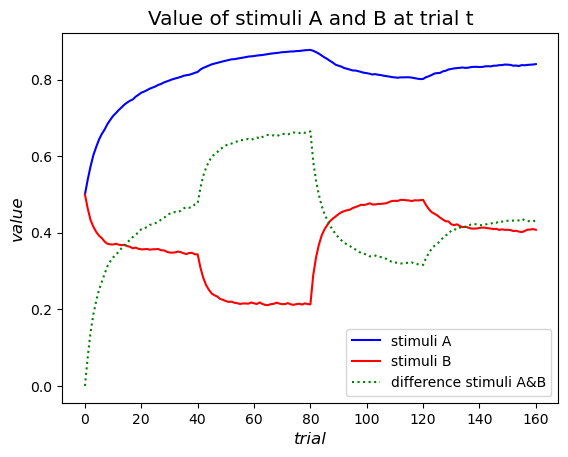

In [7]:
# Simulation: a = 0.4, b = 7, V0 = 0.5
# Average out the outcome for 10000 trials
np.random.seed(1)
n = 10000
value_a = np.zeros([n,161])
value_b = np.zeros([n,161])
for i in range(n):
    value_a[i] = outcome(0.4,7,prob_list,0.5)[1]
    value_b[i] = outcome(0.4,7,prob_list,0.5)[2]
value_a = np.mean(value_a,axis=0)
value_b = np.mean(value_b,axis=0)
plt.title('Value of stimuli A and B at trial t', fontsize = 'x-large')
plt.plot(value_a, color = 'b', label = "stimuli A")
plt.plot(value_b, color = 'r', label = "stimuli B")
plt.plot(np.array(value_a)-np.array(value_b), color = 'g', linestyle = 'dotted', label = "difference stimuli A&B")
plt.xlabel('trial', fontsize = 'large', fontstyle = 'italic')
plt.ylabel('value', fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='lower right')

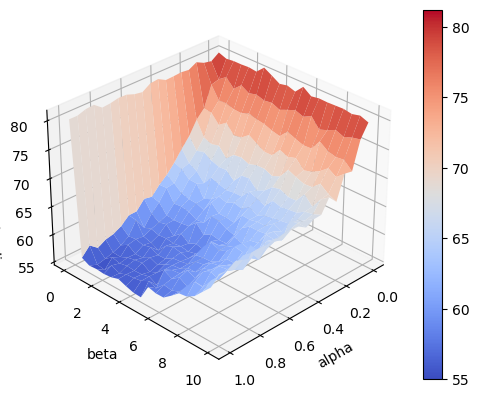

In [8]:
# Plot the average number of aversive stimuli received as a function of the parameter settings
# alpha determines the rate of learning, with higher values leading to faster learning. 
# beta determines the sensitivity to reward prediction errors, with higher values leading 
# to greater sensitivity. Thus, a higher alpha value may lead to faster adaptation to changes 
# in the environment, while a higher beta value may lead to more cautious behavior and fewer 
# aversive outcomes. However, there may be trade-offs between these parameters, as increasing 
# one parameter may negatively affect performance if the other parameter is not also adjusted appropriately. 

np.random.seed(1)
num = 20
n = 100
sim_mat = np.zeros([num,num])
alpha = (np.linspace(0,1,num))
beta = (np.linspace(0,10,num))
for i in range(num):
    for j in range(num):
        sim = np.zeros(n)
        for k in range (n):
            sim[k] = outcome(alpha[i],beta[j],prob_list,0.5)[-1]
        sim_mat[i][j] = np.mean(sim)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)
X, Y = np.meshgrid(alpha, beta)
plot = ax.plot_surface(X, Y, sim_mat, cmap='coolwarm', vmin=np.min(sim_mat), vmax=np.max(sim_mat))
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('avg aversive stimuli')
fig.colorbar(plot)

plt.show()

### Likelihood function

In [9]:
# a function that takes as input the data (choices and outcomes) for an 
# individual and a vector of parameters (learning rate and inverse temperature) 
# and returns the negative log likelihood (NLL)

def nll(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))/(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i]))))
        # p_a.append(sp.special.softmax([-b*(value_a[i]),-b*(value_b[i])])[0])
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))
        # logsumexp = np.logaddexp(-b*(value_a[i]), -b*(value_b[i]))
        # p_a.append(np.ma.exp(-b*(value_a[i]) - logsumexp))
        # ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return -ll

## test should be around 61 
test = nll([0.4,7],inst_choices[8],inst_outcomes[8],0.5); print(test)
nll4 = nll([0.4,7],inst_choices[3],inst_outcomes[3],0.5); print(nll4)
nll5 = nll([0.4,7],inst_choices[4],inst_outcomes[4],0.5); print(nll5)

-60.877333438783324
-101.60502062243488
-52.68861467295331


### Model fitting

In [10]:
fitted_param = []
for i in range(len(stai_scores)):
    fitted_param.append(sp.optimize.minimize(nll,x0=(0.4,7), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)

/Users/a.i/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:942: RuntimeWarning: overflow encountered in exp
  result = self.f(d, *args, **kwargs)
/var/folders/k8/kf3w914s7_l6n18t6bqjl9280000gn/T/ipykernel_10661/2797834694.py:24: RuntimeWarning: invalid value encountered in double_scalars
  p_a.append(np.ma.exp(-b*(value_a[i]))/(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i]))))


In [11]:
fitted_alpha, fitted_beta = np.array(fitted_param).T
mean_alpha = np.mean(fitted_alpha); print(mean_alpha)
var_alpha = np.var(fitted_alpha); print(var_alpha)
mean_beta = np.mean(fitted_beta); print(mean_beta)
var_beta = np.var(fitted_beta); print(var_beta)
#sp.stats.pearsonr(fitted_alpha, fitted_beta)

0.420967381306822
0.23761104088664672
82.1828671578747
53399.68043295634


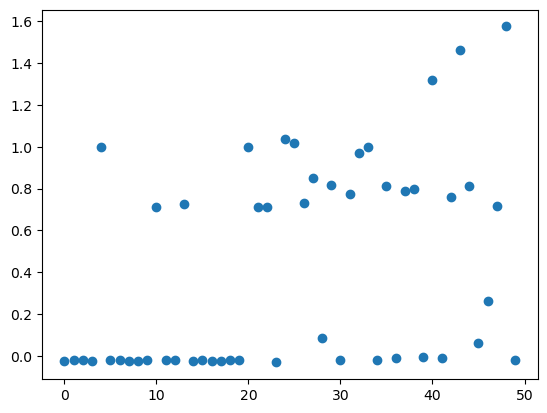

In [12]:
plt.scatter(np.arange(0,50,1),fitted_alpha)

In [13]:
fitted_beta

array([  14.34179722,   14.36920031,   14.03556201,   14.38443006,
         37.42993249,   13.98916822,   13.89144459,   15.7260611 ,
         18.96521757,   14.37811598,   40.09629521,   14.60846557,
         13.86238841,   41.05181189,   13.9262718 ,   14.14838568,
         13.91710743,   13.86694287,   14.78755087,   13.86583314,
         37.42994036,   40.26166689,   40.41116536,   14.62811373,
         34.65742065,   36.04364381,   40.88205132,  -37.42821885,
        978.53343317,  -37.43435595,   11.45620571,   41.58980576,
        -37.42992139,   37.42990499,   13.90358459,   40.20863032,
         69.58460275,   47.44955484,   40.1349291 ,  111.93172583,
         19.40740686,   69.89406082,   49.96818202,   16.70220745,
         40.16781685, 1174.53101027,  781.71718168,   41.45191956,
         11.60668065,   13.81102632])